##### Copyright 2020 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

# BERT Natural Language Processing for APSMarch2021 titles and abstracts

we'll create a search engine for the APS DPOLY titles using contextual embeddings (BERT)

This notebook is modified from
https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/bert_experts.ipynb

# BERT Experts from TF-Hub

This colab demonstrates how to:
* Load BERT models from [TensorFlow Hub](https://tfhub.dev) that have been trained on different tasks including MNLI, SQuAD, and PubMed
* Use a matching preprocessing model to tokenize raw text and convert it to ids
* Generate the pooled and sequence output from the token input ids using the loaded model
* Look at the semantic similarity of the pooled outputs of different sentences

#### Note: This colab should be run with a GPU runtime

## Set up and imports

In [ ]:
!pip3 install --quiet tensorflow
!pip3 install --quiet tensorflow_text

     |████████████████████████████████| 3.4MB 6.2MB/s 


In [ ]:
import seaborn as sns
from sklearn.metrics import pairwise
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # Imports TF ops for preprocessing.

In [ ]:
#@title Configure the model { run: "auto" }
BERT_MODEL = "https://tfhub.dev/google/experts/bert/pubmed/2" # @param {type: "string"} ["https://tfhub.dev/google/experts/bert/wiki_books/2", "https://tfhub.dev/google/experts/bert/wiki_books/mnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qqp/2", "https://tfhub.dev/google/experts/bert/wiki_books/squad2/2", "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2",  "https://tfhub.dev/google/experts/bert/pubmed/2", "https://tfhub.dev/google/experts/bert/pubmed/squad2/2"]
# Preprocessing must match the model, but all the above use the same.
PREPROCESS_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

## Download Data from github

In [ ]:
!wget https://github.com/shijiale0609/NLP_APS_abstract/raw/main/APSMarch2021.pkl
!wget https://github.com/shijiale0609/NLP_APS_abstract/raw/main/title_bert_pubmed_embeddings.pkl

--2021-02-15 16:23:51--  https://github.com/shijiale0609/NLP_APS_abstract/raw/main/APSMarch2021.pkl
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/shijiale0609/NLP_APS_abstract/main/APSMarch2021.pkl [following]
--2021-02-15 16:23:51--  https://raw.githubusercontent.com/shijiale0609/NLP_APS_abstract/main/APSMarch2021.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15725598 (15M) [application/octet-stream]
Saving to: ‘APSMarch2021.pkl’

APSMarch2021.pkl    100%[===================>]  15.00M  80.0MB/s    in 0.2s    

2021-02-15 16:23:51 (80.0 MB/s) - ‘APSMarch2021.pkl’ saved [15725598/15725598

In [ ]:
## Read the data
df = pd.read_pickle('APSMarch2021.pkl')

We train 500 titles since the limit of the memory

In [ ]:
## get the titles for all the abstract. 
title_list = df['Title'].tolist()
sentences = title_list[0:500]

## Run the model

We'll load the BERT model from TF-Hub, tokenize our sentences using the matching preprocessing model from TF-Hub, then feed in the tokenized sentences to the model. To keep this colab fast and simple, we recommend running on GPU.

Go to **Runtime** → **Change runtime type** to make sure that **GPU** is selected

In [ ]:
%%time

preprocess = hub.load(PREPROCESS_MODEL)
bert = hub.load(BERT_MODEL)
inputs = preprocess(sentences)
outputs = bert(inputs)

CPU times: user 24.4 s, sys: 5.06 s, total: 29.4 s
Wall time: 31.1 s


In [ ]:
embeddings = outputs['pooled_output']

If you want to train all the remaining titles, run the cell below. 

In [ ]:
#for i in range(1,21):
  
#  left = 500*i
#  right = 500*(i+1)
#  if right >=len(title_list):
#    right = len(title_list)
#  print (i, left, right)
#  inputs = preprocess(title_list[left:right])
#  outputs = bert(inputs)
#  # Here we use the default embedding, which is a fixed mean-pooling of all contextualized word representations or in other words, sentence embedding instead of word embedding (see https://tfhub.dev/google/elmo/2)
#  embeddings_new = outputs['pooled_output']
#  embeddings = tf.concat([embeddings, embeddings_new], 0)

#pickle.dump(embeddings, open("title_bert_pubmed_embeddings.pkl", "wb"))

In [ ]:
embeddings.shape

TensorShape([10094, 768])

## Use the fullembeddings which are already trained

In [ ]:
fullembeddings = pickle.load(open('title_bert_pubmed_embeddings.pkl','rb'))

In [ ]:
%%time

search_string = ["free energy calculation"]
#search_string = ["Colloidal Diamond"]
input_search = preprocess(search_string)
outputs_search = bert(input_search)

CPU times: user 16.3 ms, sys: 2.05 ms, total: 18.3 ms
Wall time: 17.2 ms


In [ ]:
print("string preprocess:",len(input_search))
print ("output:",outputs_search['pooled_output'].shape)

string preprocess: 3
output: (1, 768)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
res = cosine_similarity(outputs_search['pooled_output'],fullembeddings).flatten()

In [ ]:
res1 = res.ravel().argsort()[-10:]
res1 = res1.tolist()
res1.reverse()

print ("Top" + str(10), "titles for '{}':\n\n".format(search_string[0]))
#print (res[title_list.index("Free energy landscapes and transition rates of dynamic properties of Au4 neutral and charged clusters at finite temperature")])
for i in range(0, len(res1)):
    print(i+1, "cosine similarity = ", res[res1[i]], '\n', "Title:",title_list[res1[i]],'\n', "url:", df['url'][res1[i]])

Top10 titles for 'free energy calculation':


1 cosine similarity =  0.46114743 
 Title: Finite-size transitions in membranes 
 url: https://meetings.aps.org/Meeting/MAR21/Session/L12.1
2 cosine similarity =  0.43685436 
 Title: Instanton Crystal Phase 
 url: https://meetings.aps.org/Meeting/MAR21/Session/X44.10
3 cosine similarity =  0.42551526 
 Title: Different MXenes but the same surface 
 url: https://meetings.aps.org/Meeting/MAR21/Session/C57.1
4 cosine similarity =  0.42453635 
 Title: Active Crystallization 
 url: https://meetings.aps.org/Meeting/MAR21/Session/R24.11
5 cosine similarity =  0.4070391 
 Title: Rare Event Kinetics of Ion Pairing in Solution 
 url: https://meetings.aps.org/Meeting/MAR21/Session/Y26.1
6 cosine similarity =  0.3983469 
 Title: Superhydrophobicity induced by CO2 plasma treatment of Magnesium 
 url: https://meetings.aps.org/Meeting/MAR21/Session/X41.13
7 cosine similarity =  0.39339346 
 Title: Settling of shaped solids 
 url: https://meetings.aps.org/

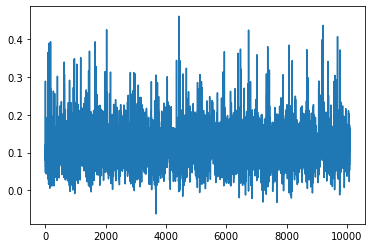

In [ ]:
import matplotlib.pyplot as plt

plt.plot(res)